# 1.  Data reading and preprocessing

In [73]:
import pandas as pd

In [78]:
url = "https://drive.google.com/file/d/1P5-3duf5x4zSoL0H3Bz0f45aWoAxV7zK/view?usp=sharing"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

data = pd.read_csv(path)
data.head()

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,Expensive
0,8450,65.0,856,3,0,0,2,0,0,0
1,9600,80.0,1262,3,1,0,2,298,0,0
2,11250,68.0,920,3,1,0,2,0,0,0
3,9550,60.0,756,3,1,0,3,0,0,0
4,14260,84.0,1145,4,1,0,3,192,0,0


### 1.1. Set X and y

In [79]:
X = data
y = X.pop("Expensive")

### 1.2. Split the data

In [80]:
from sklearn.model_selection import train_test_split

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                            y,
                                                            test_size=0.2,
                                                            random_state=123)

## 1.4. Impute missing values

(Fit on train, transform train & test)

In [82]:
from sklearn.impute import SimpleImputer

my_imputer = SimpleImputer().set_output(transform='pandas') # initialise
my_imputer.fit(X_train) # fit on the train set
X_imputed_train = my_imputer.transform(X_train) # transform the train set
X_imputed_test = my_imputer.transform(X_test) # transform the test set

## 1.5. Modelling: Decision Tree

In [83]:
from sklearn.tree import DecisionTreeClassifier

Initialize the model.

In [84]:
my_tree = DecisionTreeClassifier(max_depth=4,
                                 min_samples_leaf=10
                                )

Fit the model to the train data.

In [85]:
my_tree.fit(X = X_imputed_train,
            y = y_train)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=10)

# 1.6. Check accuracy on the train set

In [86]:
from sklearn.metrics import accuracy_score

Use the model and the preprocessed train data to make predictions.




In [87]:
y_pred_tree_train = my_tree.predict(X_imputed_train)

In [88]:
y_pred_tree_train

array([1, 0, 0, ..., 0, 0, 0])

Take the predicted values and the data from y train, and compare them with each other. The greater the share of correct predictions is, the closer the accuracy score will be to 1.


In [89]:
accuracy_score(y_true = y_train,
               y_pred = y_pred_tree_train)

0.9238013698630136

## 1.7. Check accuracy on the test set


To check whether our model is only good at predicting the values it was trained on (overfitting) or also useful to predict new data:

use the model and the preprocessed test data to make predictions.

In [90]:
y_pred_tree_test = my_tree.predict(X_imputed_test)

Then, take the predicted values and the data from y test, and compare them with each other.

Ideally, the accuracy for the train and the test data is similar.

In [91]:
accuracy_score(y_true = y_test,
               y_pred = y_pred_tree_test)

0.9212328767123288

# 2.&nbsp; Pipeline creation

In [92]:
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline

# 2.1 Initialize transformer and model

In [93]:
imputer = SimpleImputer(strategy="median")
dtree = DecisionTreeClassifier(max_depth=4,
                               min_samples_leaf=10,
                               random_state=42)

# 2.2 Create a pipeline

In [94]:
pipe = make_pipeline(imputer, dtree).set_output(transform='pandas')

In [95]:
pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=4, min_samples_leaf=10,
                                        random_state=42))])

Note that make_pipeline is just a slightly more concise function than Pipeline, as it does not require you to name each step, but their behaviour is equivalent.

In [96]:
from sklearn.pipeline import Pipeline
pipe_2 = Pipeline([("imputer", imputer), ("classifier", dtree)]).set_output(transform='pandas')

In [97]:
pipe_2

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('classifier',
                 DecisionTreeClassifier(max_depth=4, min_samples_leaf=10,
                                        random_state=42))])

## 2.3 Fit the pipeline to the training data


In [98]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=4, min_samples_leaf=10,
                                        random_state=42))])

If you want pipe steps presented like text:

In [99]:
from sklearn import set_config

set_config(display="text")
pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=4, min_samples_leaf=10,
                                        random_state=42))])

To switch back to diagram:

In [100]:
set_config(display="diagram")
pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=4, min_samples_leaf=10,
                                        random_state=42))])

## 2.4 Use the pipeline to make predictions

In [101]:
y_pred_tree_test_pipe = pipe.predict(X_test)

In [102]:
accuracy_score(y_true = y_test,
               y_pred = y_pred_tree_test_pipe)

0.9212328767123288

Now, the object pipe can take (almost) raw data as input and output predictions. We no longer need to impute missing values and use the model to make predictions in separate steps.

# 3.  Use GridSearchCV to find the best parameters of the model

So far, we tuned the hyperparameters of the decision tree manually. This is not ideal, for two reasons:

It's not efficient in terms of quickly finding the best combination of parameters.
If we keep checking the performance on the test set over and over again, we might end up creating a model that fits that particular test set, but does not generalize as well with new data. Test sets are meant to reamain unseen until the very last moment of ML development —we have been cheating a bit!
Grid Search Cross Validation solves both issues:

In [103]:
# 1. initialize transformers & model without specifying the parameters
imputer = SimpleImputer()
dtree = DecisionTreeClassifier()

In [104]:
# 2. Create a pipeline
pipe = make_pipeline(imputer, dtree).set_output(transform='pandas')

In [105]:
pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

To define the parameter grid for cross validation, you need to create a dictionary, where:

The keys are the name of the pipeline step, followed by two underscores and the name of the parameter you want to tune.
The values are lists (or "ranges") with all the values you want to try for each parameter.

In [106]:
for value in range(2, 12, 2):
    print(value)

2
4
6
8
10


In [107]:
param_grid = {
    'decisiontreeclassifier__max_depth': range(2, 12),
    'decisiontreeclassifier__min_samples_leaf': range(3, 10, 2),
    'decisiontreeclassifier__min_samples_split': range(3, 40, 5),
    'decisiontreeclassifier__criterion':['gini', 'entropy']
    }

When defining the cross validation, we want to pass our pipeline (pipe), our parameter grid (param_grid) and the number of folds (an arbitrary number, usually 5 or 10). You can also define the parameter verbose if you want to recieve a bit more info about the CV task.

In [108]:
from sklearn.model_selection import GridSearchCV

In [109]:
search = GridSearchCV(pipe, # you have defined this beforehand
                      param_grid, # your parameter grid
                      cv=5, # the value for K in K-fold Cross Validation
                      scoring='accuracy', # the performance metric to use,
                      verbose=1) # we want informative outputs during the training process, try changing it to 2 and see what happens

Fit your "search" to the training data (X and y), as we used to do with our model alone or with our pipeline:

In [110]:
search.fit(X_train, y_train)

Fitting 5 folds for each of 640 candidates, totalling 3200 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             param_grid={'decisiontreeclassifier__criterion': ['gini',
                                                               'entropy'],
                         'decisiontreeclassifier__max_depth': range(2, 12),
                         'decisiontreeclassifier__min_samples_leaf': range(3, 10, 2),
                         'decisiontreeclassifier__min_samples_split': range(3, 40, 5)},
             scoring='accuracy', verbose=1)

Explore the best parameters and the best score achieved with your cross validation:

In [112]:
search.best_params_

{'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 6,
 'decisiontreeclassifier__min_samples_leaf': 3,
 'decisiontreeclassifier__min_samples_split': 33}

In [113]:
# the mean cross-validated score of the best estimator
search.best_score_

0.9255236418326547

In [114]:
# training accuracy
y_predtrain_ = search.predict(X_train)

train_accuracy = accuracy_score(y_train, y_train_pred)
print('Train Accuracy:', round(train_accuracy,2))

Train Accuracy: 0.94


In [115]:
# testing accuracy
y_test_pred = search.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
print('Train Accuracy:', round(test_accuracy,2))

Train Accuracy: 0.92


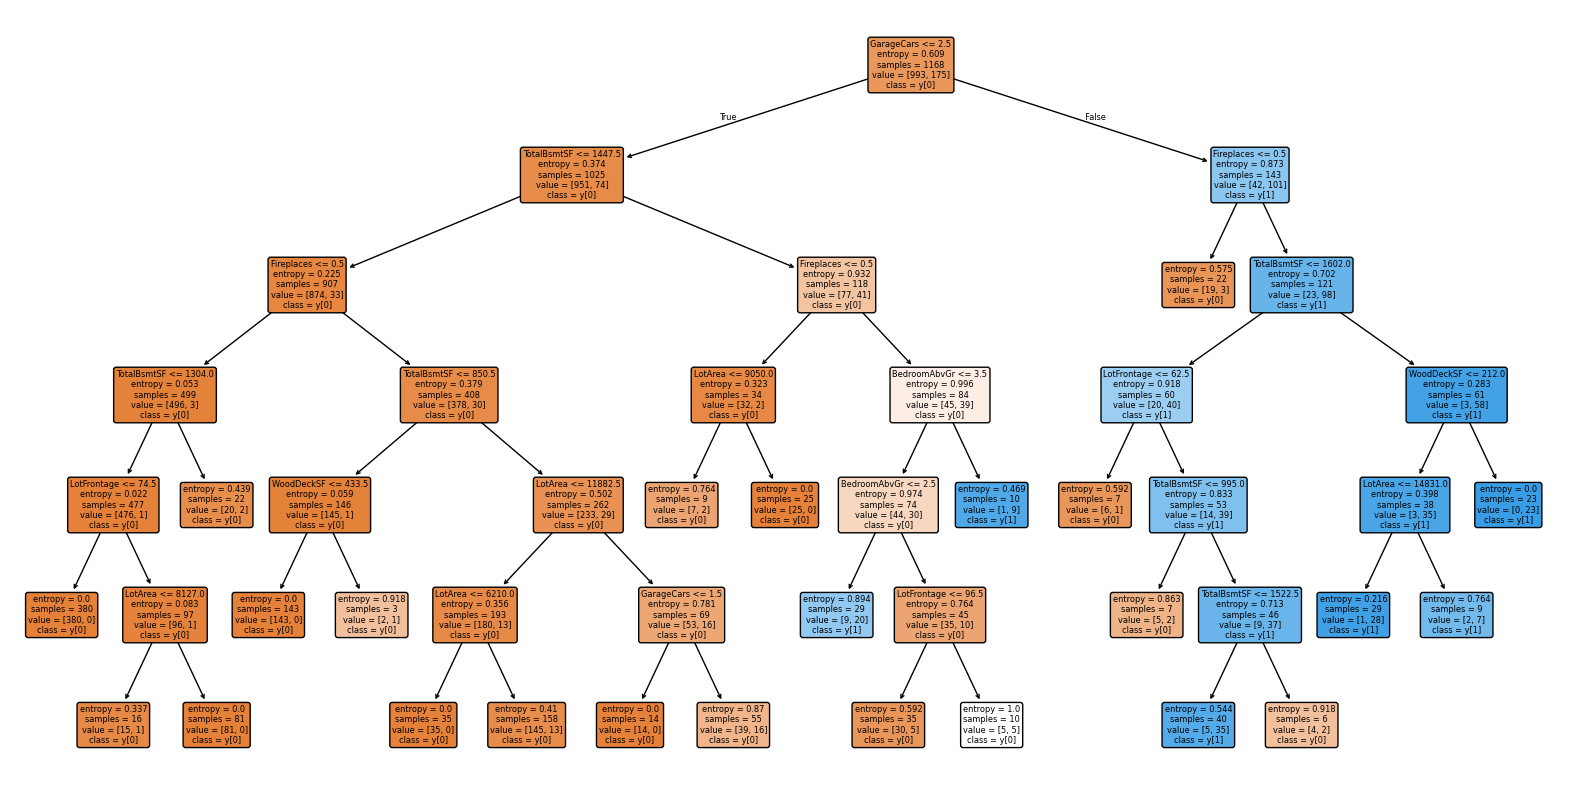

In [116]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Example parameters
params = {
    'criterion': 'entropy',
    'max_depth': 6,
    'min_samples_leaf': 3,
    'min_samples_split': 33
}

# Initialize the DecisionTreeClassifier with the specified parameters
tree = DecisionTreeClassifier(**params)

# Assuming X_train and y_train are your training data features and labels
tree.fit(X_train, y_train)

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree, filled=True, feature_names=X_train.columns, class_names=True, rounded=True)
plt.show()


# 4.  Use GridSearchCV to find the best parameters of the pipeline

Add a scaler to the pipeline, and use GridSearchCV to tune the parameters of the scaler, as well as the parameters of the imputer and the decision tree.

This shows how Grid Search Cross Validation can be used to not only tune the parameters of the model but also the parameters of all the transformers in a pipeline, thus helping us find the best preprocessing strategy for our data.

In [117]:
from sklearn.preprocessing import StandardScaler

In [118]:
# initialize transformers & model
imputer = SimpleImputer()
scaler = StandardScaler()
dtree = DecisionTreeClassifier()

In [119]:
# create the pipeline
pipe = make_pipeline(imputer,
                     scaler,
                     dtree).set_output(transform='pandas')

In [120]:
pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [121]:
# create parameter grid
param_grid = {
    "simpleimputer__strategy":["mean", "median"],
    "standardscaler__with_mean":[True, False],
    "standardscaler__with_std":[True, False],
    "decisiontreeclassifier__max_depth": range(2, 14),
    "decisiontreeclassifier__min_samples_leaf": range(3, 10),
    "decisiontreeclassifier__criterion":["gini", "entropy"]
}

In [122]:
# define cross validation
search = GridSearchCV(pipe,
                      param_grid,
                      cv=10,
                      verbose=1,
                      n_jobs=-1)

In [123]:
# fit
search.fit(X_train, y_train)

Fitting 10 folds for each of 1344 candidates, totalling 13440 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('standardscaler', StandardScaler()),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__criterion': ['gini',
                                                               'entropy'],
                         'decisiontreeclassifier__max_depth': range(2, 14),
                         'decisiontreeclassifier__min_samples_leaf': range(3, 10),
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler__with_mean': [True, False],
                         'standardscaler__with_std': [True, False]},
             verbose=1)

In [124]:
# cross validation average accuracy
search.best_score_

0.9263778367226644

In [125]:
# best parameters
search.best_params_

{'decisiontreeclassifier__criterion': 'gini',
 'decisiontreeclassifier__max_depth': 5,
 'decisiontreeclassifier__min_samples_leaf': 6,
 'simpleimputer__strategy': 'mean',
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True}

In [126]:
# training accuracy
y_predtrain_ = search.predict(X_train)

train_accuracy1 = accuracy_score(y_train, y_train_pred)
print('Train Accuracy:', round(train_accuracy1,2))

Train Accuracy: 0.94


In [127]:
# testing accuracy
y_test_pred = search.predict(X_test)

test_accuracy1 = accuracy_score(y_test, y_test_pred)
print('Train Accuracy:', round(test_accuracy1,2))

Train Accuracy: 0.93


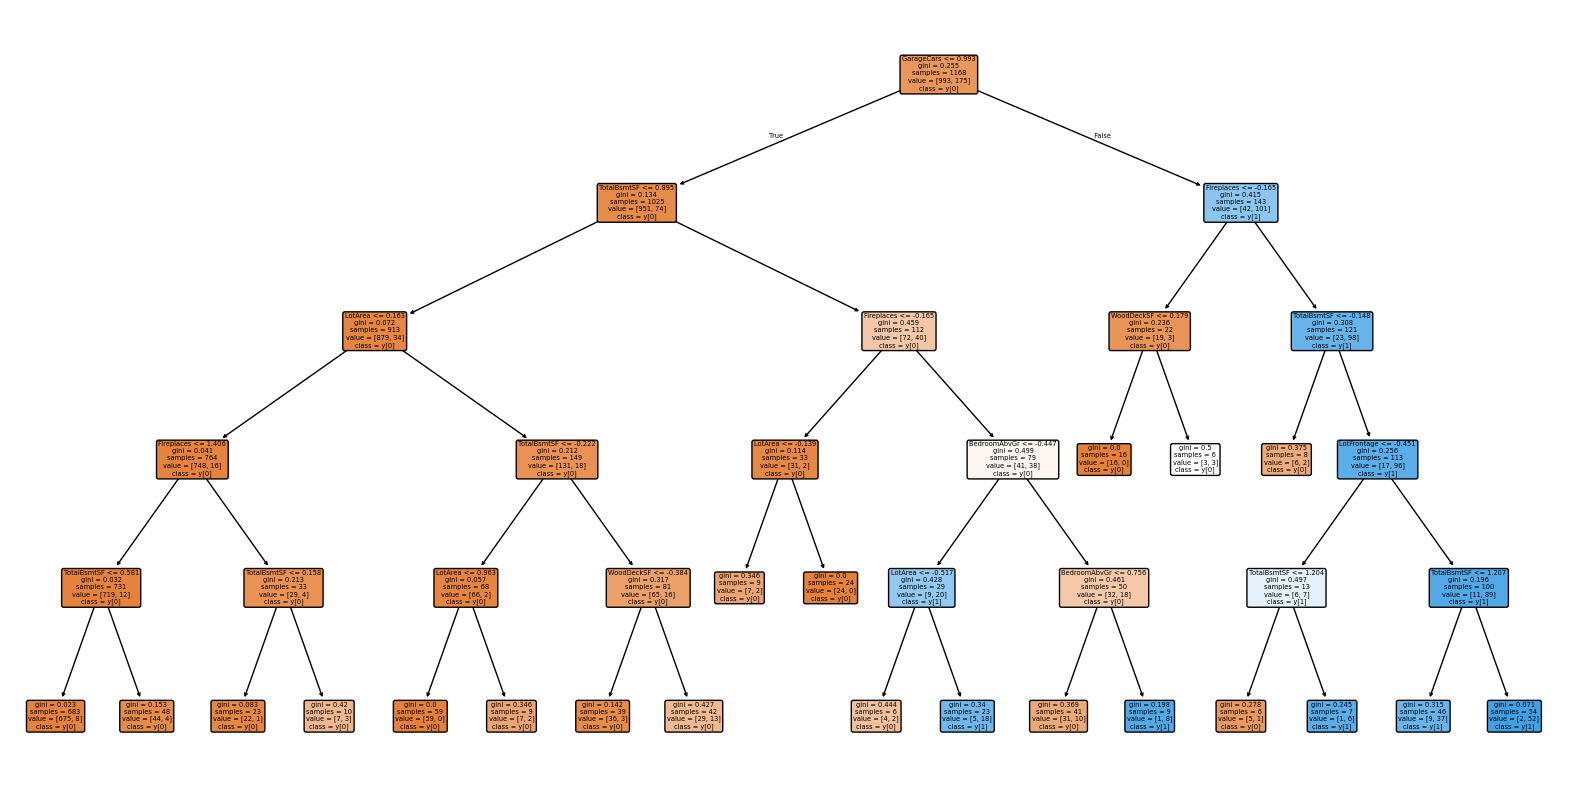

In [128]:
# Define pipeline steps based on the given parameters
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler(with_mean=True, with_std=True)),
    ('classifier', DecisionTreeClassifier(
        criterion='gini',
        max_depth=5,
        min_samples_leaf=6
    ))
])

# Assuming X_train and y_train are your training data features and labels
pipeline.fit(X_train, y_train)

# Extract the trained DecisionTreeClassifier from the pipeline
tree = pipeline.named_steps['classifier']

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree, filled=True, feature_names=X_train.columns, class_names=True, rounded=True)
plt.show()


In [129]:
from sklearn.tree import export_text

# Export the tree as text
tree_text = export_text(tree, feature_names=list(X_train.columns))
print(tree_text)


|--- GarageCars <= 0.99
|   |--- TotalBsmtSF <= 0.89
|   |   |--- LotArea <= 0.16
|   |   |   |--- Fireplaces <= 1.41
|   |   |   |   |--- TotalBsmtSF <= 0.58
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- TotalBsmtSF >  0.58
|   |   |   |   |   |--- class: 0
|   |   |   |--- Fireplaces >  1.41
|   |   |   |   |--- TotalBsmtSF <= 0.16
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- TotalBsmtSF >  0.16
|   |   |   |   |   |--- class: 0
|   |   |--- LotArea >  0.16
|   |   |   |--- TotalBsmtSF <= -0.22
|   |   |   |   |--- LotArea <= 0.96
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- LotArea >  0.96
|   |   |   |   |   |--- class: 0
|   |   |   |--- TotalBsmtSF >  -0.22
|   |   |   |   |--- WoodDeckSF <= -0.38
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- WoodDeckSF >  -0.38
|   |   |   |   |   |--- class: 0
|   |--- TotalBsmtSF >  0.89
|   |   |--- Fireplaces <= -0.17
|   |   |   |--- LotArea <= -0.14
|   |   |   |   |--- class: 0
|   |   |   |--- LotAre

# 5. Use RandomizedSearchCV to find the best parameters of the pipeline

In [138]:
# Pipeline with preprocessing and classifier
pipeline = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier())
])

# Define the parameter distribution for RandomizedSearchCV
param_distributions = {
    'imputer__strategy': ['mean', 'median'],
    'scaler__with_mean': [True, False],
    'scaler__with_std': [True, False],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': np.arange(2, 14),
    'classifier__min_samples_leaf': np.arange(3, 10),
    'classifier__min_samples_split': np.arange(2, 10)
}

# Initialize RandomizedSearchCV with the pipeline and parameter distribution
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=20,  # Number of parameter combinations to try
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    random_state=42  # For reproducibility
)

# Fit RandomizedSearchCV to the training data
random_search.fit(X_train, y_train)

# Output the best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Score:", round(random_search.best_score_, 2))


Best Parameters: {'scaler__with_std': False, 'scaler__with_mean': True, 'imputer__strategy': 'median', 'classifier__min_samples_split': 6, 'classifier__min_samples_leaf': 6, 'classifier__max_depth': 5, 'classifier__criterion': 'entropy'}
Best Cross-Validation Score: 0.92


In [139]:
# Get the best estimator (pipeline with the best parameters)
best_model = random_search.best_estimator_

# Calculate training accuracy
y_train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", round(train_accuracy, 2))

# Calculate test accuracy
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", round(test_accuracy, 2))


Training Accuracy: 0.94
Test Accuracy: 0.93


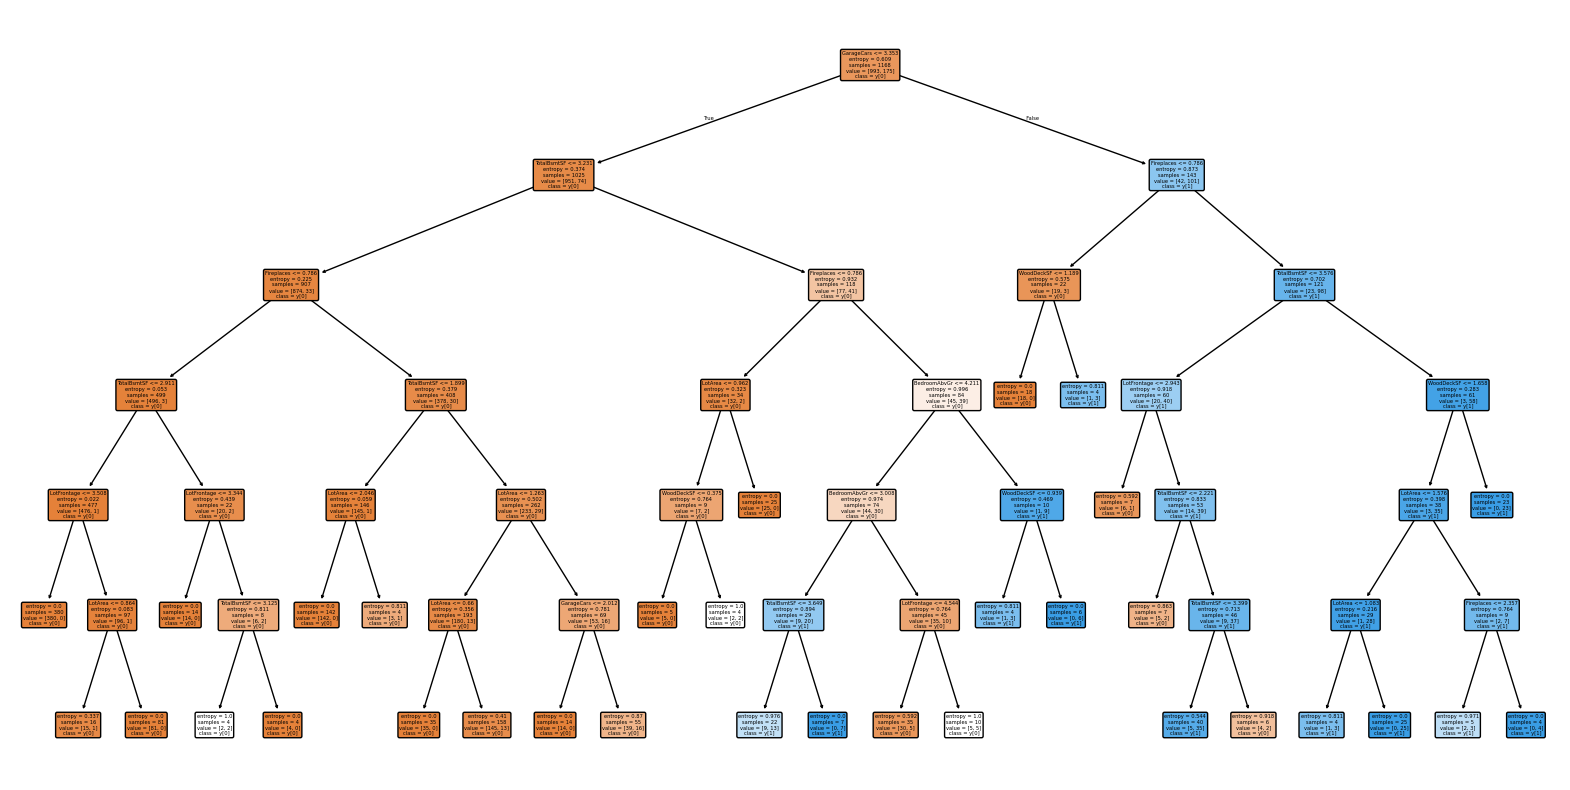

In [141]:
# Define the pipeline with the best parameters
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False, with_std=True)),
    ('classifier', DecisionTreeClassifier(
        criterion='entropy',
        max_depth=6,
        min_samples_leaf=4,
        min_samples_split=6
    ))
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Extract the trained DecisionTreeClassifier from the pipeline
tree = pipeline.named_steps['classifier']

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree, filled=True, feature_names=X_train.columns, class_names=True, rounded=True)
plt.show()
